In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler
import joblib
import warnings
warnings.filterwarnings('ignore')

# ANN imports
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasClassifier


In [2]:
# Load dataset
df = pd.read_csv('/content/Copy of bankruptcy-prevention.csv')

# Clean column names
df.columns = df.columns.str.strip()

# Map target variable
df['class'] = df['class'].map({'non-bankruptcy': 0, 'bankruptcy': 1})

# Display dataset info
print("Dataset shape:", df.shape)
print(df.info())
print(df.describe())
print("Missing values:\n", df.isnull().sum())

# Display first few records
display(df.head())


Dataset shape: (250, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   industrial_risk        250 non-null    float64
 1   management_risk        250 non-null    float64
 2   financial_flexibility  250 non-null    float64
 3   credibility            250 non-null    float64
 4   competitiveness        250 non-null    float64
 5   operating_risk         250 non-null    float64
 6   class                  250 non-null    int64  
dtypes: float64(6), int64(1)
memory usage: 13.8 KB
None
       industrial_risk  management_risk  financial_flexibility  credibility  \
count       250.000000       250.000000             250.000000   250.000000   
mean          0.518000         0.614000               0.376000     0.470000   
std           0.411526         0.410705               0.401583     0.415682   
min           0.000000         0

industrial_risk  management_risk  financial_flexibility  credibility  \
0              0.5              1.0                    0.0          0.0   
1              0.0              1.0                    0.0          0.0   
2              1.0              0.0                    0.0          0.0   
3              0.5              0.0                    0.0          0.5   
4              1.0              1.0                    0.0          0.0   

   competitiveness  operating_risk  class  
0              0.0             0.5      1  
1              0.0             1.0      1  
2              0.0             1.0      1  
3              0.0             1.0      1  
4              0.0             1.0      1

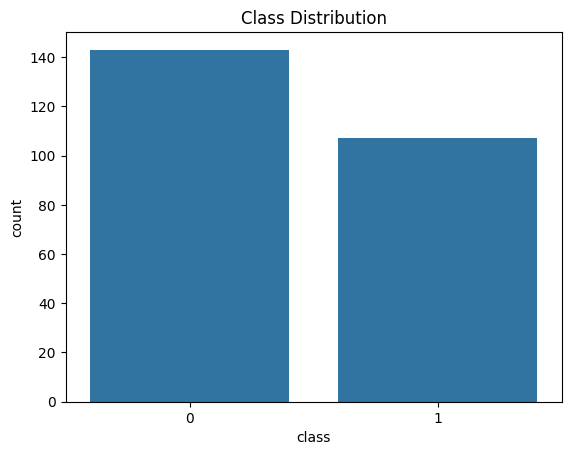

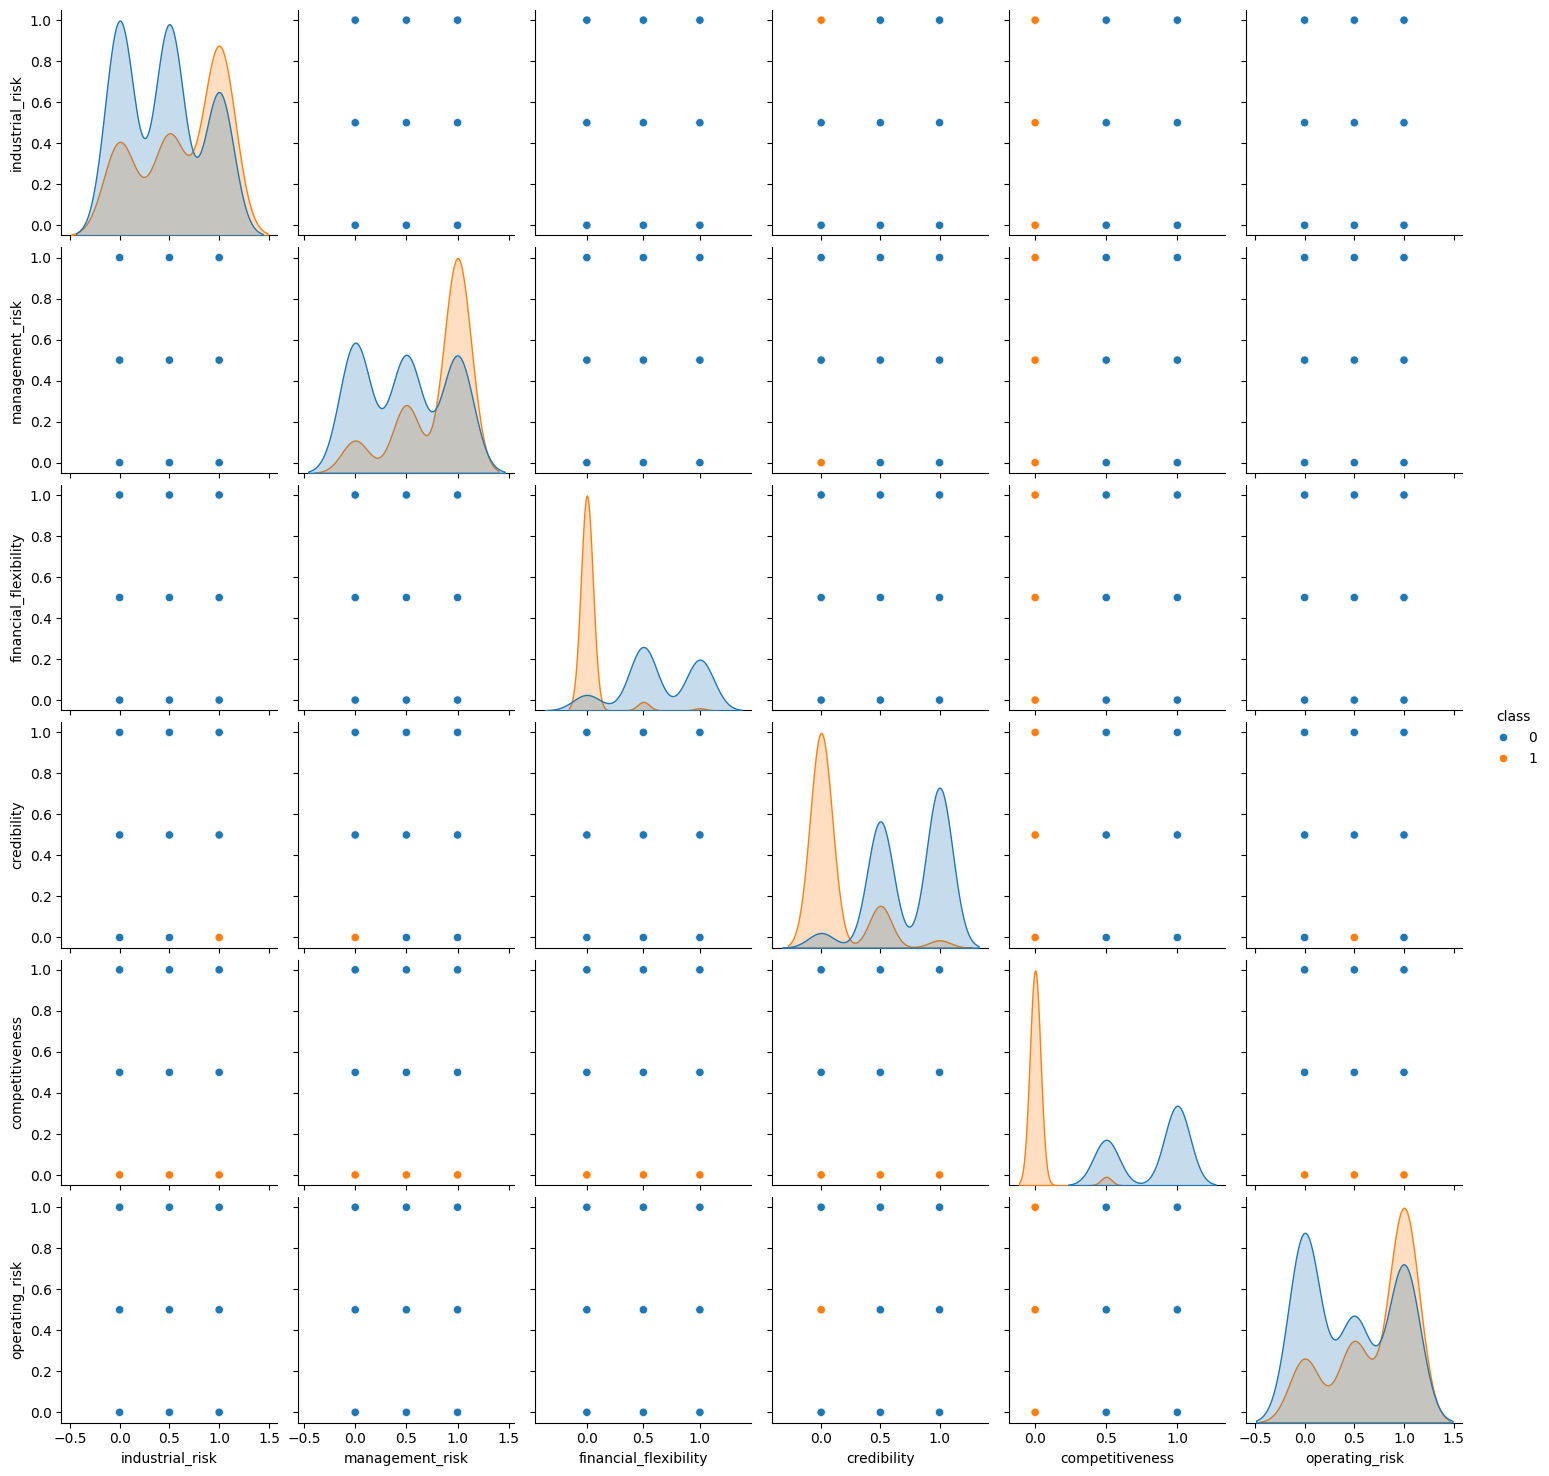

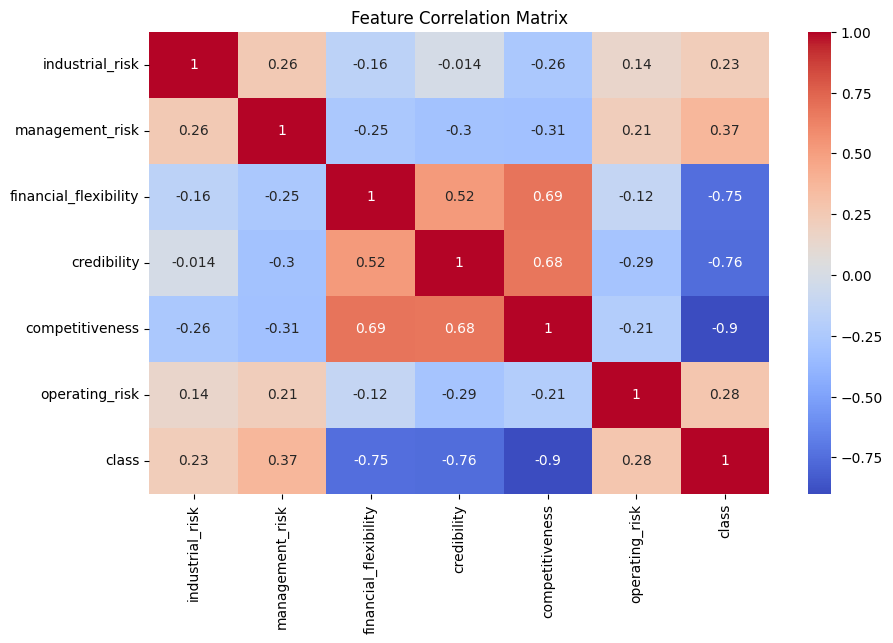

In [3]:
# Visualize class distribution
sns.countplot(x='class', data=df)
plt.title('Class Distribution')
plt.show()

# Pairplot for feature distribution by class
sns.pairplot(df, vars=df.columns[:-1], hue='class')
plt.show()

# Correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Matrix")
plt.show()


In [4]:
feature_names = ['industrial_risk', 'management_risk', 'financial_flexibility', 'credibility',
                 'competitiveness', 'operating_risk']

X = df[feature_names]
y = df['class']

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [5]:
models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    "KNN": KNeighborsClassifier()
}

results = {}

for name, clf in models.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {acc:.4f}")
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    results[name] = (clf, acc)


Logistic Regression Accuracy: 1.0000
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        29
           1       1.00      1.00      1.00        21

    accuracy                           1.00        50
   macro avg       1.00      1.00      1.00        50
weighted avg       1.00      1.00      1.00        50

Confusion Matrix:
 [[29  0]
 [ 0 21]]
Decision Tree Accuracy: 0.9800
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.98        29
           1       0.95      1.00      0.98        21

    accuracy                           0.98        50
   macro avg       0.98      0.98      0.98        50
weighted avg       0.98      0.98      0.98        50

Confusion Matrix:
 [[28  1]
 [ 0 21]]
Random Forest Accuracy: 1.0000
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00 

In [6]:
def create_ann():
    model = Sequential()
    model.add(Dense(8, input_dim=len(feature_names), activation='relu'))
    model.add(Dense(4, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

ann = KerasClassifier(model=create_ann, epochs=100, batch_size=16, verbose=0)
ann.fit(X_train, y_train)

# Predict and evaluate ANN
y_pred_ann = ann.predict(X_test)
ann_acc = accuracy_score(y_test, y_pred_ann)
print(f"ANN Accuracy: {ann_acc:.4f}")
print("ANN Classification Report:\n", classification_report(y_test, y_pred_ann))

results["ANN"] = (ann, ann_acc)


ANN Accuracy: 1.0000
ANN Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        29
           1       1.00      1.00      1.00        21

    accuracy                           1.00        50
   macro avg       1.00      1.00      1.00        50
weighted avg       1.00      1.00      1.00        50



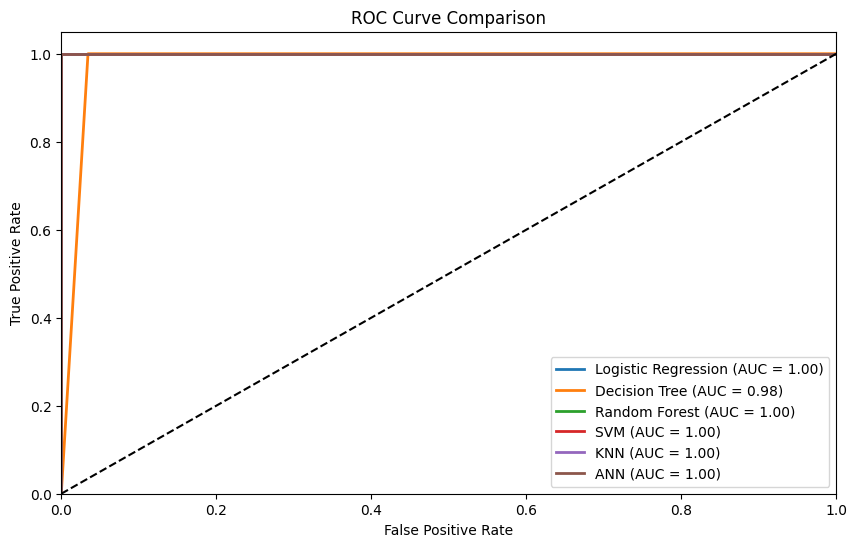

In [7]:
plt.figure(figsize=(10, 6))

for name, (model, _) in results.items():
    if name == "ANN":
        # SciKeras's predict_proba returns probabilities for both classes, select the probabilities for class 1
        y_proba = ann.predict_proba(X_test)[:, 1]
    else:
        y_proba = model.predict_proba(X_test)[:, 1]

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc="lower right")
plt.show()

In [8]:
param_grid = {
    "n_estimators": [50, 100, 150],
    "max_depth": [None, 5, 10],
    "min_samples_split": [2, 5]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train, y_train)

print("Best Random Forest Parameters:", grid_search.best_params_)

best_rf = grid_search.best_estimator_

y_pred_best = best_rf.predict(X_test)
print("Optimized Random Forest Classification Report:")
print(classification_report(y_test, y_pred_best))


Best Random Forest Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}
Optimized Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        29
           1       1.00      1.00      1.00        21

    accuracy                           1.00        50
   macro avg       1.00      1.00      1.00        50
weighted avg       1.00      1.00      1.00        50



In [9]:
best_model_name = max(results, key=lambda name: results[name][1])
best_model, best_acc = results[best_model_name]

print(f"Best Model: {best_model_name} with accuracy {best_acc:.4f}")

if best_model_name != "ANN":
    joblib.dump((best_model, feature_names), 'bankruptcy_model.pkl')
else:
    ann.model_.save('bankruptcy_ann_model.h5')
    joblib.dump(feature_names, 'ann_feature_names.pkl')


Best Model: Logistic Regression with accuracy 1.0000


## Predict Risk for New Input

This code allows you to input new data and get a risk prediction (low risk or high risk) using the best-performing model.

In [10]:
# Assuming 'best_model' and 'scaler' are available from previous steps,
# and 'feature_names' contains the list of features used for training.

def predict_bankruptcy_risk(input_data, model, scaler, feature_names):
    """
    Predicts bankruptcy risk for a single input data point.

    Args:
        input_data (dict): A dictionary where keys are feature names and values are the input values.
        model: The trained machine learning model.
        scaler: The fitted StandardScaler object.
        feature_names (list): A list of feature names used for training.

    Returns:
        str: The predicted risk level ('Low Risk' or 'High Risk').
    """
    # Create a pandas DataFrame from the input data
    input_df = pd.DataFrame([input_data])

    # Ensure the input DataFrame has the same columns as the training data and in the same order
    # Add missing columns with default value 0 if necessary
    for col in feature_names:
        if col not in input_df.columns:
            input_df[col] = 0
    input_df = input_df[feature_names]

    # Scale the input data
    input_scaled = scaler.transform(input_df)

    # Predict the class
    prediction = model.predict(input_scaled)

    # Map the prediction back to risk level
    risk_level = 'High Risk' if prediction[0] == 1 else 'Low Risk'

    return risk_level

# Example Usage:
# Replace these values with your actual input data
new_data = {
    'industrial_risk': 0.5,
    'management_risk': 0.5,
    'financial_flexibility': 0.5,
    'credibility': 0.5,
    'competitiveness': 0.5,
    'operating_risk': 0.5,
    'total_risk': 3.0, # Include the engineered features
    'industrial_management_risk': 0.25,
    'financial_credibility': 0.25
}

# Make the prediction
predicted_risk = predict_bankruptcy_risk(new_data, best_model, scaler, feature_names)

print(f"The predicted bankruptcy risk is: {predicted_risk}")

The predicted bankruptcy risk is: Low Risk


In [11]:
# Example Usage with high risk data:
# Replace these values with your actual input data
new_data_high_risk = {
    'industrial_risk': 1.0,
    'management_risk': 1.0,
    'financial_flexibility': 0.0,
    'credibility': 0.0,
    'competitiveness': 0.0,
    'operating_risk': 1.0,
    'total_risk': 4.0, # Adjusted total_risk based on component values
    'industrial_management_risk': 1.0,
    'financial_credibility': 0.0
}

# Make the prediction with the high risk data
predicted_risk_high = predict_bankruptcy_risk(new_data_high_risk, best_model, scaler, feature_names)

print(f"The predicted bankruptcy risk for the high-risk input is: {predicted_risk_high}")

The predicted bankruptcy risk for the high-risk input is: High Risk
